In [2]:
import numpy as np
import pandas as pd

import os
# Assuming the GitHub repository contains the 'data gambar' folder
# Replace with the actual GitHub repository URL
github_repo_url = 'https://github.com/HamzahShafa5317/SusuScanner'
clone_dir = '/content/SusuScanner'

# Clone the GitHub repository
if not os.path.exists(clone_dir):
    !git clone {github_repo_url} {clone_dir}
else:
    print(f"Repository already cloned to {clone_dir}")


# Path ke folder data within the cloned repository
data_dir = os.path.join(clone_dir, 'data gambar')
data_train = os.path.join(data_dir, 'train')
data_test = os.path.join(data_dir, 'test')

# Verify the paths exist
if not os.path.exists(data_train):
    print(f"Error: Training data directory not found at {data_train}")
if not os.path.exists(data_test):
    print(f"Error: Test data directory not found at {data_test}")

Cloning into '/content/SusuScanner'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 282 (delta 30), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (282/282), 1.24 MiB | 18.73 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Error: Training data directory not found at /content/SusuScanner/data gambar/train
Error: Test data directory not found at /content/SusuScanner/data gambar/test


In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

data_train = "/content/SusuScanner/image/train"
data_test = "/content/SusuScanner/image/test"

#preproccesing
def convert_df(dataset, sample_size=None):
    img_dir = Path(dataset)
    filenames = list(img_dir.rglob('*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))
    if len(filenames) == 0:
        raise ValueError(f"No images found in the directory {dataset}")
    if sample_size:
        sample_indices = np.random.choice(len(filenames), sample_size, replace=False)
        filenames = [filenames[i] for i in sample_indices]
        labels = [labels[i] for i in sample_indices]
    filenames = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filenames, labels], axis=1)
    return image_df


In [4]:
# Sampling the dataset to a smaller size for testing
sample_size = 300  # Adjust this size as needed
image_train = convert_df(data_train, sample_size)
image_test = convert_df(data_test, sample_size)

In [5]:
def extract_hog_features(image_paths, img_size=(128, 128)):
    hog_features = []
    for img_path in image_paths:
        image = imread(img_path)
        image_resized = resize(image, img_size)  # Resize image
        image_gray = rgb2gray(image_resized)
        features = hog(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    if len(hog_features) == 0:
        raise ValueError("No HOG features extracted. Check if the images are being loaded correctly.")
    return np.array(hog_features)

# --- Ekstraksi Fitur HOG ---
X_train_hog = extract_hog_features(image_train['Filepath'])
X_test_hog = extract_hog_features(image_test['Filepath'])


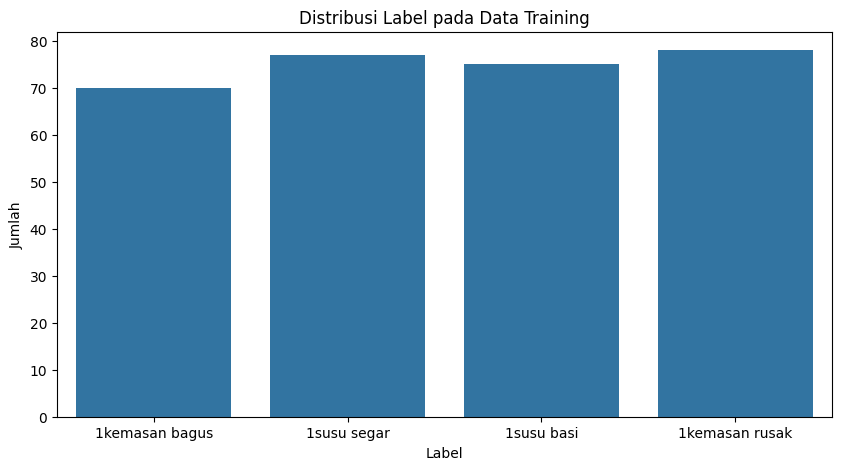


Statistik Deskriptif Fitur HOG:
             0           1           2           3           4           5     \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.138821    0.063388    0.062463    0.081154    0.143811    0.042381   
std      0.132115    0.093059    0.087157    0.115161    0.136093    0.064614   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.014657    0.000000    0.000000    0.000000    0.006401    0.000000   
50%      0.089401    0.017215    0.026502    0.019188    0.103399    0.009486   
75%      0.257081    0.088844    0.081681    0.107311    0.264292    0.059310   
max      0.501435    0.367714    0.417573    0.377991    0.443416    0.309936   

             6           7           8           9     ...        8090  \
count  300.000000  300.000000  300.000000  300.000000  ...  300.000000   
mean     0.045450    0.055502    0.089550    0.195773  ...    0.121654   
std      0.0752

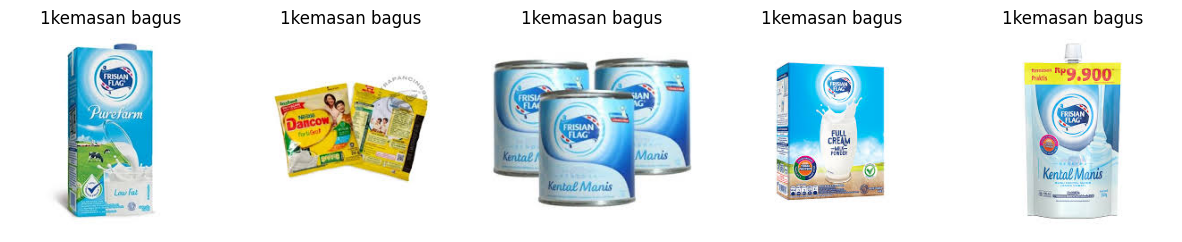

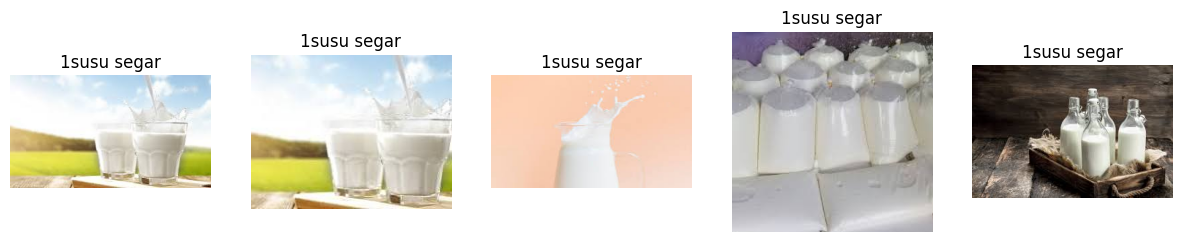

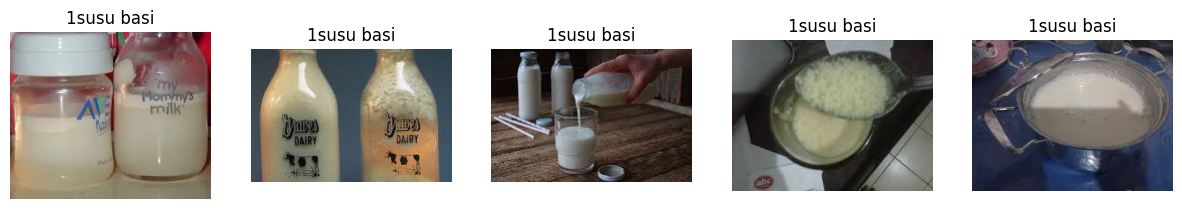

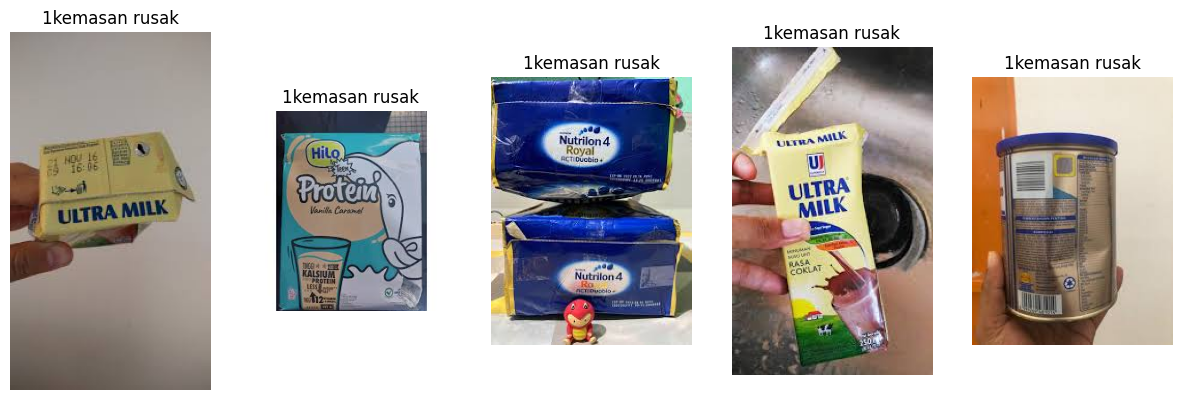


Visualisasi Gambar per Kelas (Test Set):


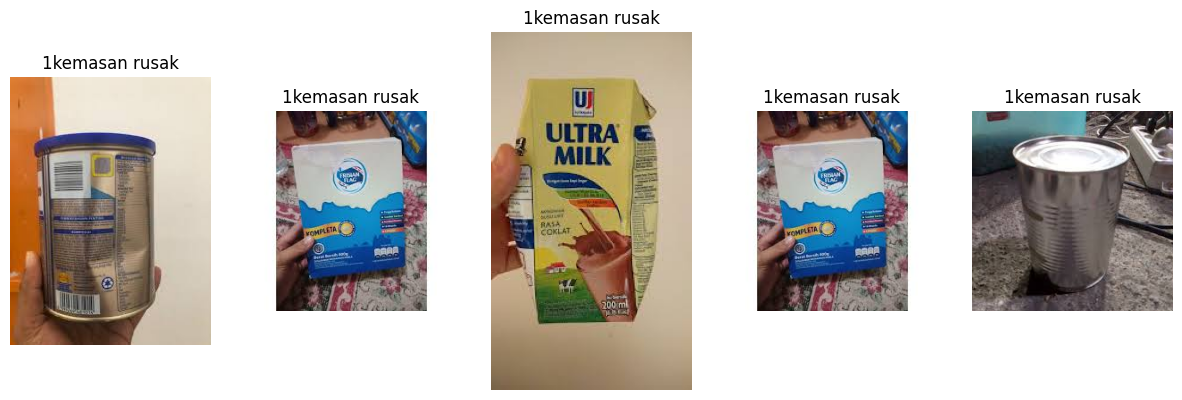

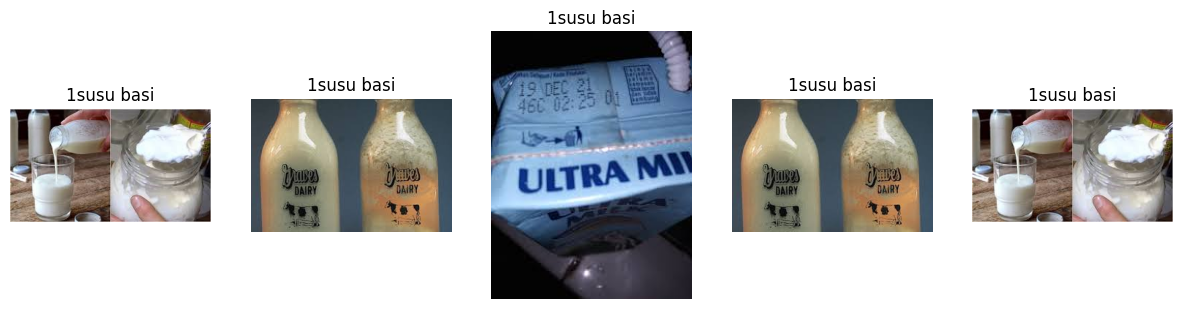

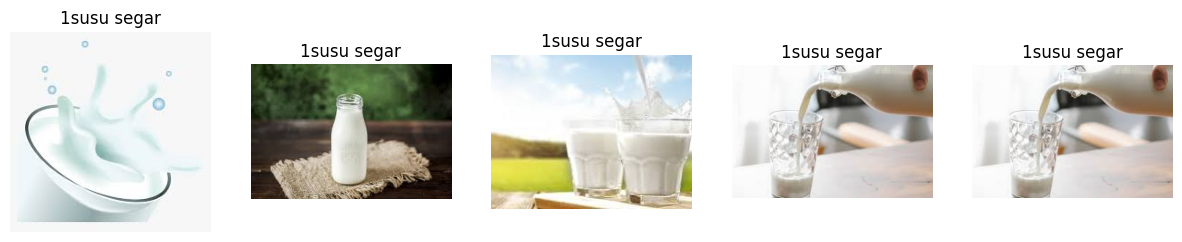

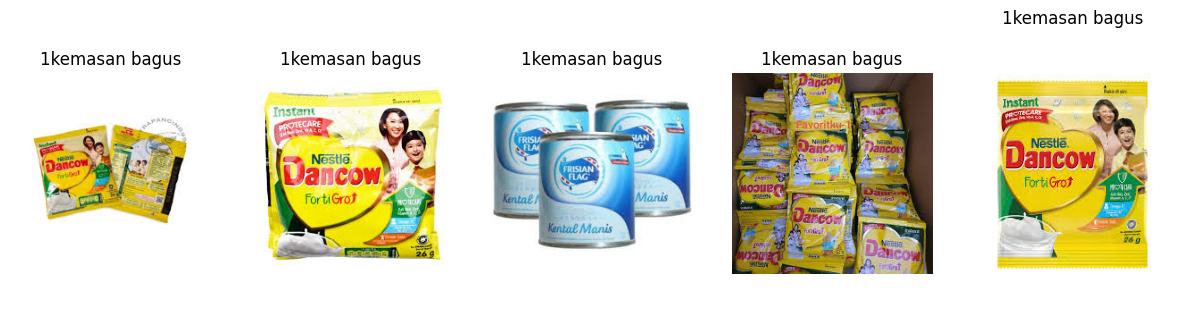

In [6]:
#EDA
# 1. Distribusi Label
plt.figure(figsize=(10, 5))
sns.countplot(x='Label', data=image_train)
plt.title('Distribusi Label pada Data Training')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

# 2. Statistik Deskriptif Fitur HOG
hog_features_df = pd.DataFrame(X_train_hog)
print("\nStatistik Deskriptif Fitur HOG:")
print(hog_features_df.describe())

# 3. Visualisasi Gambar per Kelas
def visualize_images_per_class(image_df, num_images=5):
    unique_labels = image_df['Label'].unique()
    for label in unique_labels:
        subset = image_df[image_df['Label'] == label].sample(num_images)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i, ax in enumerate(axes.flat):
            img = imread(subset['Filepath'].iloc[i])
            ax.imshow(img)
            ax.set_title(label)
            ax.axis('off')
        plt.show()

print("\nVisualisasi Gambar per Kelas (Training Set):")
visualize_images_per_class(image_train)

print("\nVisualisasi Gambar per Kelas (Test Set):")
visualize_images_per_class(image_test)

In [7]:
# Sampling the dataset to a smaller size for testing
sample_size = 300  # Adjust this size as needed
image_train = convert_df(data_train, sample_size)
image_test = convert_df(data_test, sample_size)

def extract_hog_features(image_paths, img_size=(128, 128)):
    hog_features = []
    for img_path in image_paths:
        image = imread(img_path)
        image_resized = resize(image, img_size)  # Resize image
        image_gray = rgb2gray(image_resized)
        features = hog(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    if len(hog_features) == 0:
        raise ValueError("No HOG features extracted. Check if the images are being loaded correctly.")
    return np.array(hog_features)

X_train_hog = extract_hog_features(image_train['Filepath'])
X_test_hog = extract_hog_features(image_test['Filepath'])

# Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(image_train['Label'])
y_test_encoded = le.transform(image_test['Label'])


# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_hog, y_train_encoded, test_size=0.2, random_state=42)

# Normalisasi fitur HOG after splitting
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)
X_test_scaled = scaler.transform(X_test_hog)

y_train = y_train_split # Assign the split and encoded labels back to y_train and y_val
y_val = y_val_split
y_test = y_test_encoded # Assign the encoded test labels to y_test

In [11]:
# Normalisasi fitur HOG after splitting
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Scale the split training, validation, and test sets
# Pastikan X_train_split, X_val_split, X_test_hog, y_train, y_val, dan y_test
# sudah terdefinisi dari sel-sel sebelumnya.
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)
X_test_scaled = scaler.transform(X_test_hog)

# Inisiasi model SVM untuk RFE
svm_model_rfe = SVC(kernel='linear', C=1) # Gunakan model SVM terpisah untuk RFE jika perlu

num_features = 50  # Sesuaikan jumlah fitur yang ingin dipilih
# Latih RFE pada data training yang sudah diskalakan dan dibagi
# Menggunakan X_train_split dan y_train yang sudah terdefinisi dari sel sebelumnya
rfe_selector = RFE(estimator=svm_model_rfe, n_features_to_select=num_features, step=1)
rfe_selector.fit(X_train_split, y_train) # Menggunakan X_train_split dan y_train


# Dapatkan fitur-fitur yang terpilih
selected_features = rfe_selector.support_

# Terapkan Feature Selection pada data training dan testing yang sudah diskalakan
X_train_selected = X_train_split[:, selected_features] # Terapkan pada X_train_split
X_test_selected = X_test_hog[:, selected_features] # Terapkan pada X_test_hog

# Latih model SVM dengan fitur yang terpilih (menggunakan data training yang sudah diskalakan dan dipilih fiturnya)
# Anda bisa menggunakan instance SVM yang sama atau yang baru, tergantung kebutuhan.
# Menggunakan instance baru untuk menghindari potensi masalah side effect dari RFE
svm_model_final = SVC(kernel='linear', C=1) # Inisialisasi model final
svm_model_final.fit(X_train_selected, y_train) # Latih model final dengan data training yang sudah dipilih fiturnya

SVC(C=1, kernel='linear')

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier


# Inisiasi model KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Sesuaikan jumlah tetangga (n_neighbors)

# Inisiasi SelectKBest dengan model KNN dan jumlah fitur yang ingin dipilih
num_features_knn = 30  # Sesuaikan jumlah fitur
selector_knn = SelectKBest(k=num_features_knn)  # Menggunakan skor default (f_classif)

# Latih SelectKBest pada data training
selector_knn.fit(X_train_hog, y_train)

selected_features_knn = selector_knn.get_support()

# Terapkan Feature Selection pada data training dan testing
X_train_selected_knn = X_train_hog[:, selected_features_knn]
X_test_selected_knn = X_test_hog[:, selected_features_knn]

# Latih model KNN dengan fitur yang terpilih
knn_model.fit(X_train_selected_knn, y_train)

KNeighborsClassifier()

In [15]:
#Model 1: SVM dengan parameter yang ditingkatkan
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC(kernel='rbf', C=10, gamma='scale')
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)
print(f"SVM Akurasi: {svm_acc:.4f}")
print(classification_report(y_test, svm_pred))

SVM Akurasi: 0.9233
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        77
           1       0.96      1.00      0.98        73
           2       0.97      0.82      0.89        78
           3       0.82      0.92      0.87        72

    accuracy                           0.92       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.92      0.92       300



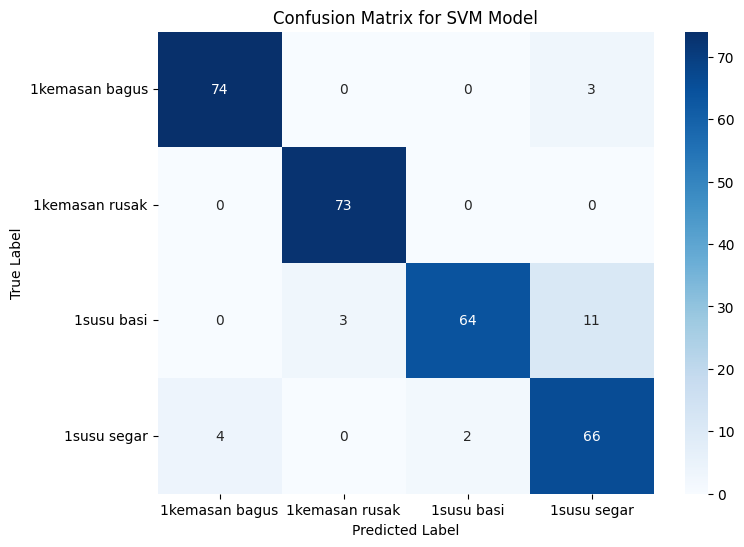

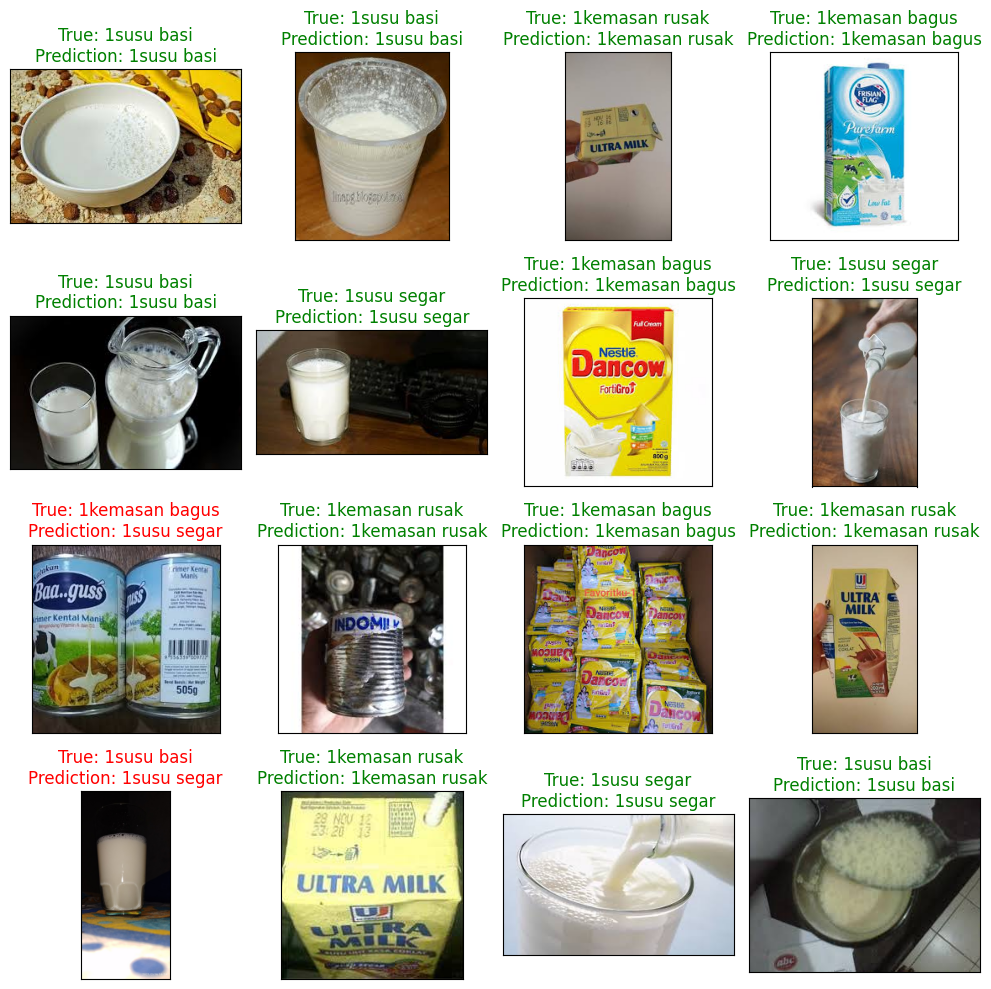

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

# Compute confusion matrix for the SVM model
cm_svm = confusion_matrix(y_test, svm_pred)

# Get the class names
target_names = ['1kemasan bagus', '1kemasan rusak', '1susu basi', '1susu segar']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM Model')
plt.show()

# Visualize some predictions for SVM
random_index = np.random.randint(0, len(image_test), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

# Inverse transform the predicted and true labels to get original class names
y_test_labels = [target_names[i] for i in y_test]
svm_pred_labels = [target_names[i] for i in svm_pred]

for i, ax in enumerate(axes.flat):
    img = imread(image_test['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    true_label = y_test_labels[random_index[i]]
    pred_label = svm_pred_labels[random_index[i]]
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}\nPrediction: {pred_label}', color=color)

plt.tight_layout()
plt.show()

In [21]:
#Model 2: K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report # Tambahkan import classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train) # Menggunakan X_train_scaled
knn_pred = knn_model.predict(X_test_scaled) # Menggunakan X_test_scaled
knn_acc = accuracy_score(y_test, knn_pred)
print(f"KNN Akurasi: {knn_acc:.4f}")

# Get the class names (assuming they are defined elsewhere, e.g., in confusion matrix cells)
# Jika target_names belum terdefinisi, Anda perlu mendefinisikannya di sini
target_names = ['1kemasan bagus', '1kemasan rusak', '1susu basi', '1susu segar']

# Tampilkan classification report
print(classification_report(y_test, knn_pred, target_names=target_names))

KNN Akurasi: 0.7833
                precision    recall  f1-score   support

1kemasan bagus       0.76      0.88      0.82        77
1kemasan rusak       0.81      0.97      0.88        73
    1susu basi       0.90      0.60      0.72        78
   1susu segar       0.69      0.68      0.69        72

      accuracy                           0.78       300
     macro avg       0.79      0.78      0.78       300
  weighted avg       0.79      0.78      0.78       300



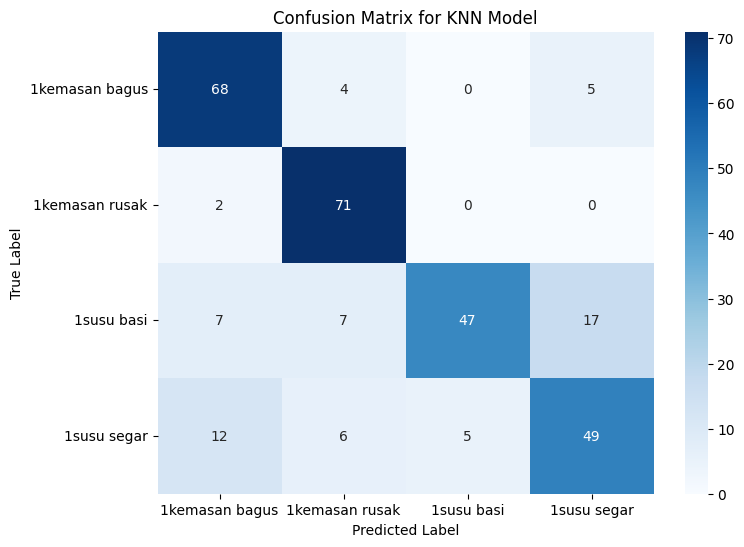

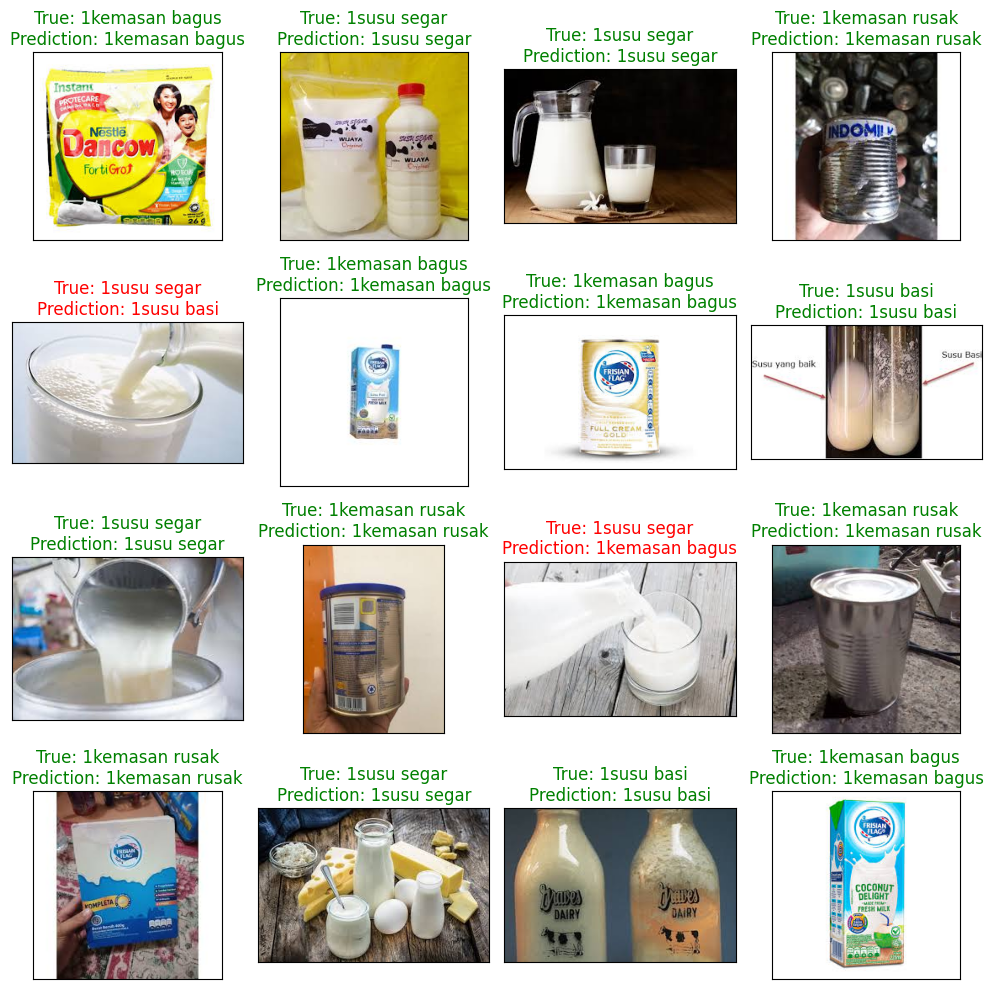

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

# Compute confusion matrix for the KNN model
cm_knn = confusion_matrix(y_test, knn_pred)

# Get the class names
target_names = ['1kemasan bagus', '1kemasan rusak', '1susu basi', '1susu segar']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Model')
plt.show()

# Visualize some predictions for KNN
random_index = np.random.randint(0, len(image_test), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

# Inverse transform the predicted and true labels to get original class names
y_test_labels = [target_names[i] for i in y_test]
knn_pred_labels = [target_names[i] for i in knn_pred]

for i, ax in enumerate(axes.flat):
    img = imread(image_test['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    true_label = y_test_labels[random_index[i]]
    pred_label = knn_pred_labels[random_index[i]]
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}\nPrediction: {pred_label}', color=color)

plt.tight_layout()
plt.show()